In [1]:
import torch
from VAE.vae import VAE
from loss.loss import vae_loss 
from optimisation.optimisation import run_optuna
from data_processing.dataload import load_normalize_data
import json
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


6.1.2


In [2]:
import torch
print(torch.cuda.is_available())        # True
print(torch.cuda.get_device_name(0))    # Nom du GPU
print(torch.cuda.memory_allocated())    # Doit être > 0 pendant l'entraînement

True
NVIDIA T400 4GB
0


In [4]:
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Important pour reproductibilité sur GPU

set_seed(42)  # Appelle ça tout en haut de ton script


In [11]:
# ============================================================
# Chargement des meilleurs paramètres
# ============================================================
with open("best_params.json", "r") as f:
    best_params = json.load(f)

latent_dim = best_params["latent_dim"]
hidden_dim = best_params["hidden_dim"]
lr = 1.59e-3                                 #   best_params["lr"]
dropout = best_params["dropout"]
print("Best parameters found:")
print("Latent dimension:", latent_dim)
print("Hidden dimension:", hidden_dim)
print("Learning rate:", lr)
print("Dropout rate:", dropout)

Best parameters found:
Latent dimension: 64
Hidden dimension: 512
Learning rate: 0.00159
Dropout rate: 0.00897690749507634


In [6]:
latent_dim = 32
hidden_dim_list = [1024, 512, 256, 128]  # 5 couches au lieu de 6
lr = 0.0001                              #   best_params["lr"]
dropout = 0
print("Best parameters found:")
print("Latent dimension:", latent_dim)
print("Hidden dimensions:", hidden_dim_list)
print("Learning rate:", lr)
print("Dropout rate:", dropout)

Best parameters found:
Latent dimension: 32
Hidden dimensions: [1024, 512, 256, 128]
Learning rate: 0.0001
Dropout rate: 0


Best parameters found:
Latent dimension: 64
Hidden dimension: 512
Learning rate: 0.0003456154007533232
Dropout rate: 0.00897690749507634

In [8]:
# ============================================================
# Chargement et normalisation des données
# ============================================================
dataset, scaler_x, scaler_y = load_normalize_data(batch_size=None, return_dataset=True)  # Adapter la fonction pour retourner le dataset complet

# Split du dataset en train et test (80%/20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Pour affichage des shapes
data_iter = iter(dataloader_train)
X_batch, y_batch = next(data_iter)
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

dim_x = X_batch.shape[1]
dim_y = y_batch.shape[1]
print("dim_x:", dim_x)
print("dim_y:", dim_y)

input_dim = dim_x + dim_y
print("Input dimension:", input_dim)

# ============================================================
# Configuration du device
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Data loaded and normalized. Returning dataset.
Train dataset size: 2872
Test dataset size: 718
X_batch shape: torch.Size([64, 4])
y_batch shape: torch.Size([64, 500])
dim_x: 4
dim_y: 500
Input dimension: 504
Using device: cuda


In [9]:
import numpy as np
from sklearn.decomposition import PCA

# Récupérer toutes les données X et Y du dataset complet
# (dataset.tensors[0] = X, dataset.tensors[1] = Y)
X_all = dataset.tensors[0].cpu().numpy()
Y_all = dataset.tensors[1].cpu().numpy()

# Concaténer X et Y sur l'axe des features
XY_data = np.concatenate([X_all, Y_all], axis=1)
print("Shape of concatenated data (X, Y):", XY_data.shape)

# Appliquer la PCA
pca = PCA()
pca.fit(XY_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
latent_dim_min = np.argmax(cumsum >= 0.99) + 1

print(f"Nombre de composantes pour 99% de variance : {latent_dim_min}")

Shape of concatenated data (X, Y): (3590, 504)
Nombre de composantes pour 99% de variance : 19


Epoch 1/1000, Train Loss: 0.9883, Val Loss: 0.9895
Epoch 2/1000, Train Loss: 0.9856, Val Loss: 0.9894
Epoch 3/1000, Train Loss: 0.9867, Val Loss: 0.9896
Epoch 4/1000, Train Loss: 0.9862, Val Loss: 0.9895
Epoch 5/1000, Train Loss: 0.9855, Val Loss: 0.9896
Epoch 6/1000, Train Loss: 0.9867, Val Loss: 0.9895
Epoch 7/1000, Train Loss: 0.9852, Val Loss: 0.9894
Epoch 8/1000, Train Loss: 0.9856, Val Loss: 0.9895
Epoch 9/1000, Train Loss: 0.9882, Val Loss: 0.9896
Epoch 10/1000, Train Loss: 0.9870, Val Loss: 0.9896
Epoch 11/1000, Train Loss: 0.9859, Val Loss: 0.9896
Epoch 12/1000, Train Loss: 0.9872, Val Loss: 0.9896
Epoch 13/1000, Train Loss: 0.9843, Val Loss: 0.9896
Epoch 14/1000, Train Loss: 0.9851, Val Loss: 0.9897
Epoch 15/1000, Train Loss: 0.9878, Val Loss: 0.9897
Epoch 16/1000, Train Loss: 0.9861, Val Loss: 0.9896
Epoch 17/1000, Train Loss: 0.9850, Val Loss: 0.9894
Epoch 18/1000, Train Loss: 0.9887, Val Loss: 0.9895
Epoch 19/1000, Train Loss: 0.9887, Val Loss: 0.9897
Epoch 20/1000, Train 

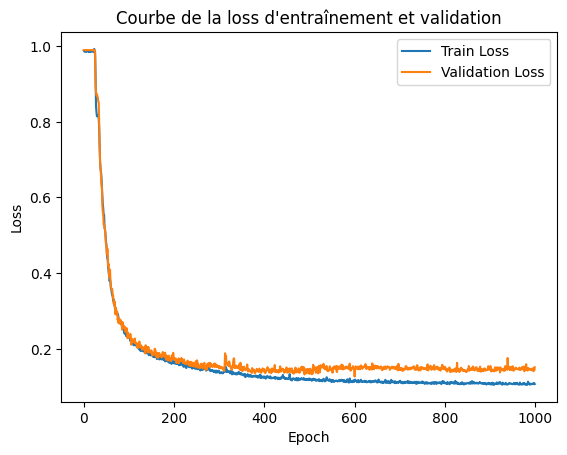

In [10]:
# ============================================================
# Initialisation du modèle et de l'optimiseur
# ============================================================
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim_list=hidden_dim_list, dropout=dropout).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=30, min_lr=1e-6)

num_epochs = 1000

# ============================================================
# Boucle d'entraînement
# ============================================================
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    epoch_loss = 0.0
    vae.train()

    for x_batch, y_batch in dataloader_train:
        xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)

        recon, mu, log_var = vae(xy_batch)
        loss_batch = vae_loss(recon, xy_batch, mu, log_var)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

        epoch_loss += loss_batch.item()

    avg_loss = epoch_loss / len(dataloader_train)
    train_losses.append(avg_loss)

    # Validation
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in dataloader_test:
            xy_val = torch.cat([x_val, y_val], dim=1).to(device)
            recon, mu, log_var = vae(xy_val)
    
            loss = vae_loss(recon, xy_val, mu, log_var)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_test)
    val_losses.append(avg_val_loss)
    #scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# ============================================================
# Affichage de la courbe de loss d'entraînement et validation
# ============================================================
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la loss d'entraînement et validation")
plt.legend()
plt.show()

In [12]:
# ============================================================
# Sauvegarde du modèle entraîné
# ============================================================
model_path = "vae_trained_1000.pth"
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'hidden_dim_list': hidden_dim_list,
    'dropout': dropout,
    'scaler_x': scaler_x,
    'scaler_y': scaler_y
}, model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous vae_trained_1000.pth


recon_x shape: (64, 4)
recon_y shape: (64, 500)
X normalisé: [-0.05628022 -0.01622241 -0.02330592 -0.14118746]
Y normalisé: [-0.10401177 -0.1060793  -0.10179156 -0.10725356 -0.11353724 -0.10584518
 -0.11376406 -0.11200504 -0.10900068 -0.11276725 -0.1136009  -0.11011234
 -0.11381833 -0.11571056 -0.10843821 -0.11709227 -0.11932335 -0.11467496
 -0.12399095 -0.12030101 -0.11948577 -0.12049796 -0.12080352 -0.1176644
 -0.1238751  -0.1252397  -0.12474038 -0.12459134 -0.12171301 -0.12576444
 -0.12444356 -0.12736084 -0.12416755 -0.11691789 -0.12635344 -0.12616196
 -0.12122141 -0.12763622 -0.13092923 -0.12869045 -0.1228363  -0.12631279
 -0.12960899 -0.13571349 -0.13021715 -0.13135494 -0.12831514 -0.12968582
 -0.12821412 -0.13143517 -0.13058327 -0.12202232 -0.12844971 -0.12375684
 -0.12830995 -0.12504828 -0.11817427 -0.11994337 -0.12260407 -0.12348481
 -0.11943404 -0.1155522  -0.10864581 -0.11285862 -0.1057061  -0.09769852
 -0.11015369 -0.10362565 -0.10358946 -0.09909716 -0.09448049 -0.10117233
 

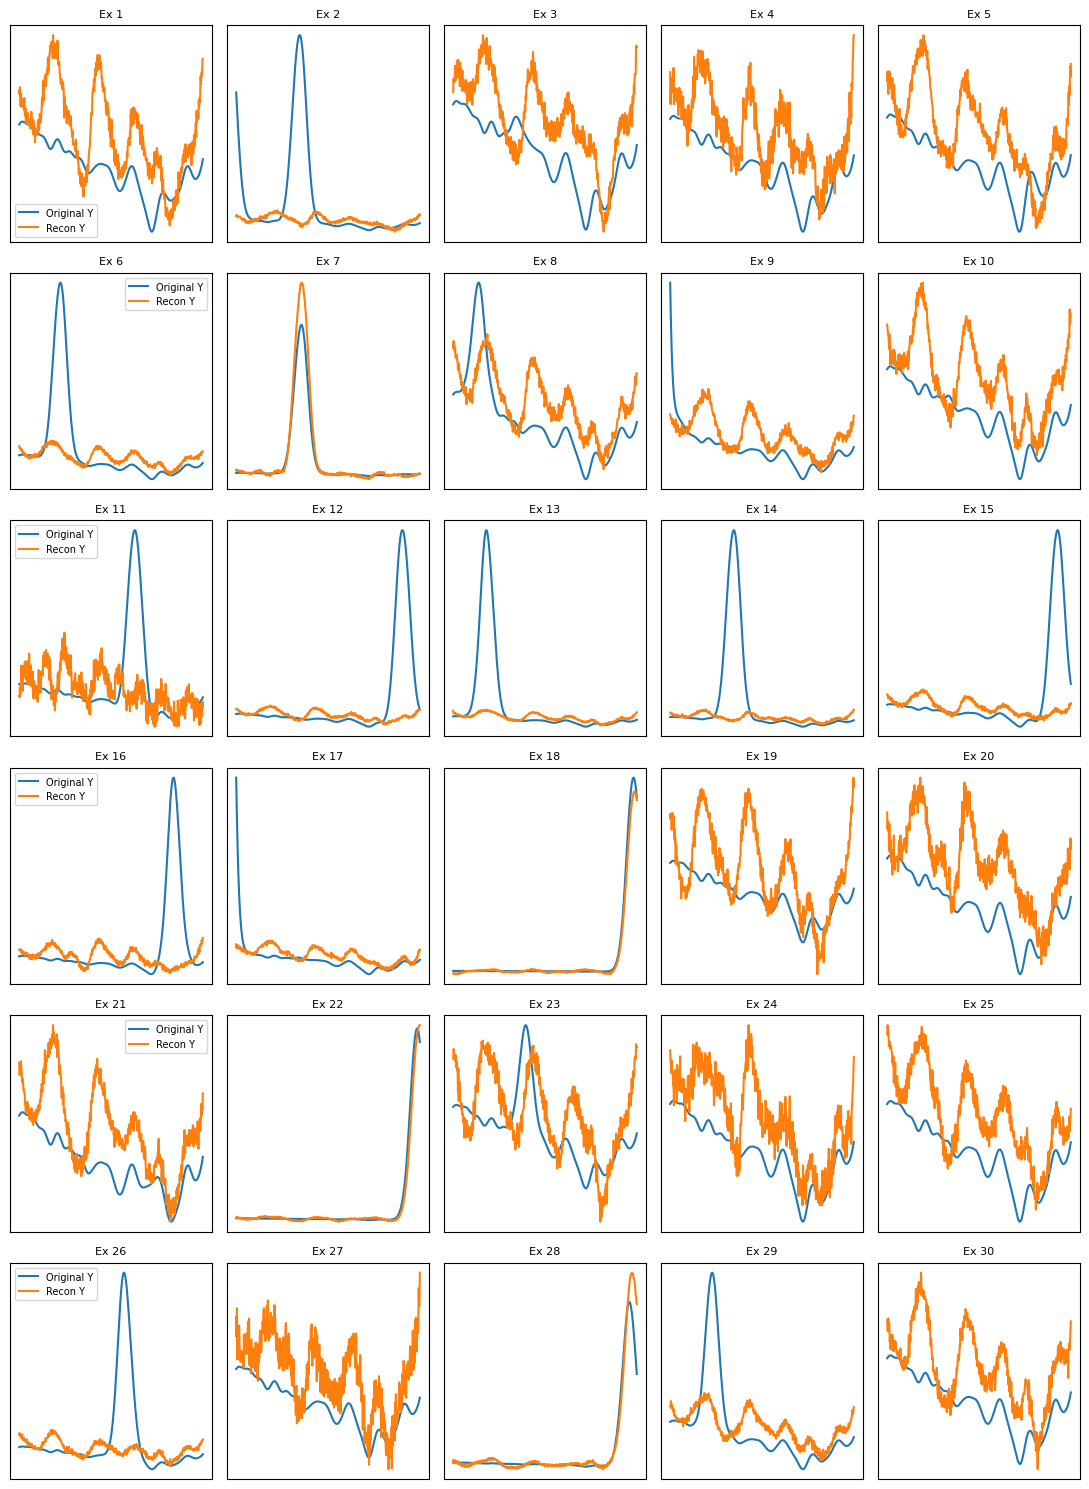

In [13]:
# ============================================================
# Prédiction et reconstruction sur un batch de test
# ============================================================

vae.eval()
with torch.no_grad():
    # Prendre un batch de test
    x_batch, y_batch = next(iter(dataloader_test))
    xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)

    # Reconstruction
    recon, mu, log_var = vae(xy_batch)

    # Convertir en numpy
    recon_np = recon.cpu().numpy()
    original_np = xy_batch.cpu().numpy()

# Séparer X et y dans la reconstruction et les données originales
recon_x = recon_np[:, :dim_x]
recon_y = recon_np[:, dim_x:]
print("recon_x shape:", recon_x.shape)
print("recon_y shape:", recon_y.shape)
print("X normalisé:", recon_x[0])
print("Y normalisé:", recon_y[0])

orig_x = original_np[:, :dim_x]
orig_y = original_np[:, dim_x:]
print("orig_x shape:", orig_x.shape)
print("orig_y shape:", orig_y.shape)
print("X normalisé:", orig_x[0])
print("Y normalisé:", orig_y[0])

n_examples = 30
n_cols = 5
n_rows = n_examples // n_cols

plt.figure(figsize=(2.2*n_cols, 2.5*n_rows))
for i in range(n_examples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(orig_y[i], label='Original Y')
    plt.plot(recon_y[i], label='Recon Y')
    plt.title(f"Ex {i+1}", fontsize=8)
    plt.xticks([])
    plt.yticks([])
    if i % n_cols == 0:
        plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

=== Données originales ===
X: [5.7500000e+02 5.0000000e-01 5.0000000e+02 4.3982295e+06]
Y: [4.58769828e-05 5.40724686e-05 5.46424708e-05 5.17660810e-05
 4.90525563e-05 5.55212755e-05 5.52085621e-05 5.29649333e-05
 5.50364748e-05 5.52016900e-05 5.53381578e-05 5.15180145e-05
 5.22269038e-05 6.43950843e-05 6.84452389e-05 6.52235030e-05
 6.44623215e-05 6.10164170e-05 6.80024532e-05 7.14852285e-05
 5.78250219e-05 7.28498344e-05 6.62626044e-05 6.35896504e-05
 5.88700022e-05 6.13641678e-05 6.08115806e-05 6.48510904e-05
 7.23523044e-05 6.98435106e-05 6.22345760e-05 5.96152458e-05
 6.68949433e-05 6.20080318e-05 7.25947029e-05 7.06793362e-05
 6.23435189e-05 5.74391270e-05 6.16756879e-05 4.33256719e-05
 5.17014305e-05 5.63826725e-05 6.86029452e-05 6.21277286e-05
 5.30358120e-05 7.82414281e-05 7.61345727e-05 6.58599529e-05
 5.12443512e-05 3.56164091e-05 6.49263675e-05 6.01692736e-05
 7.18931187e-05 6.85571067e-05 6.47900160e-05 6.12303338e-05
 6.31589646e-05 6.64556501e-05 6.17475307e-05 6.1717866

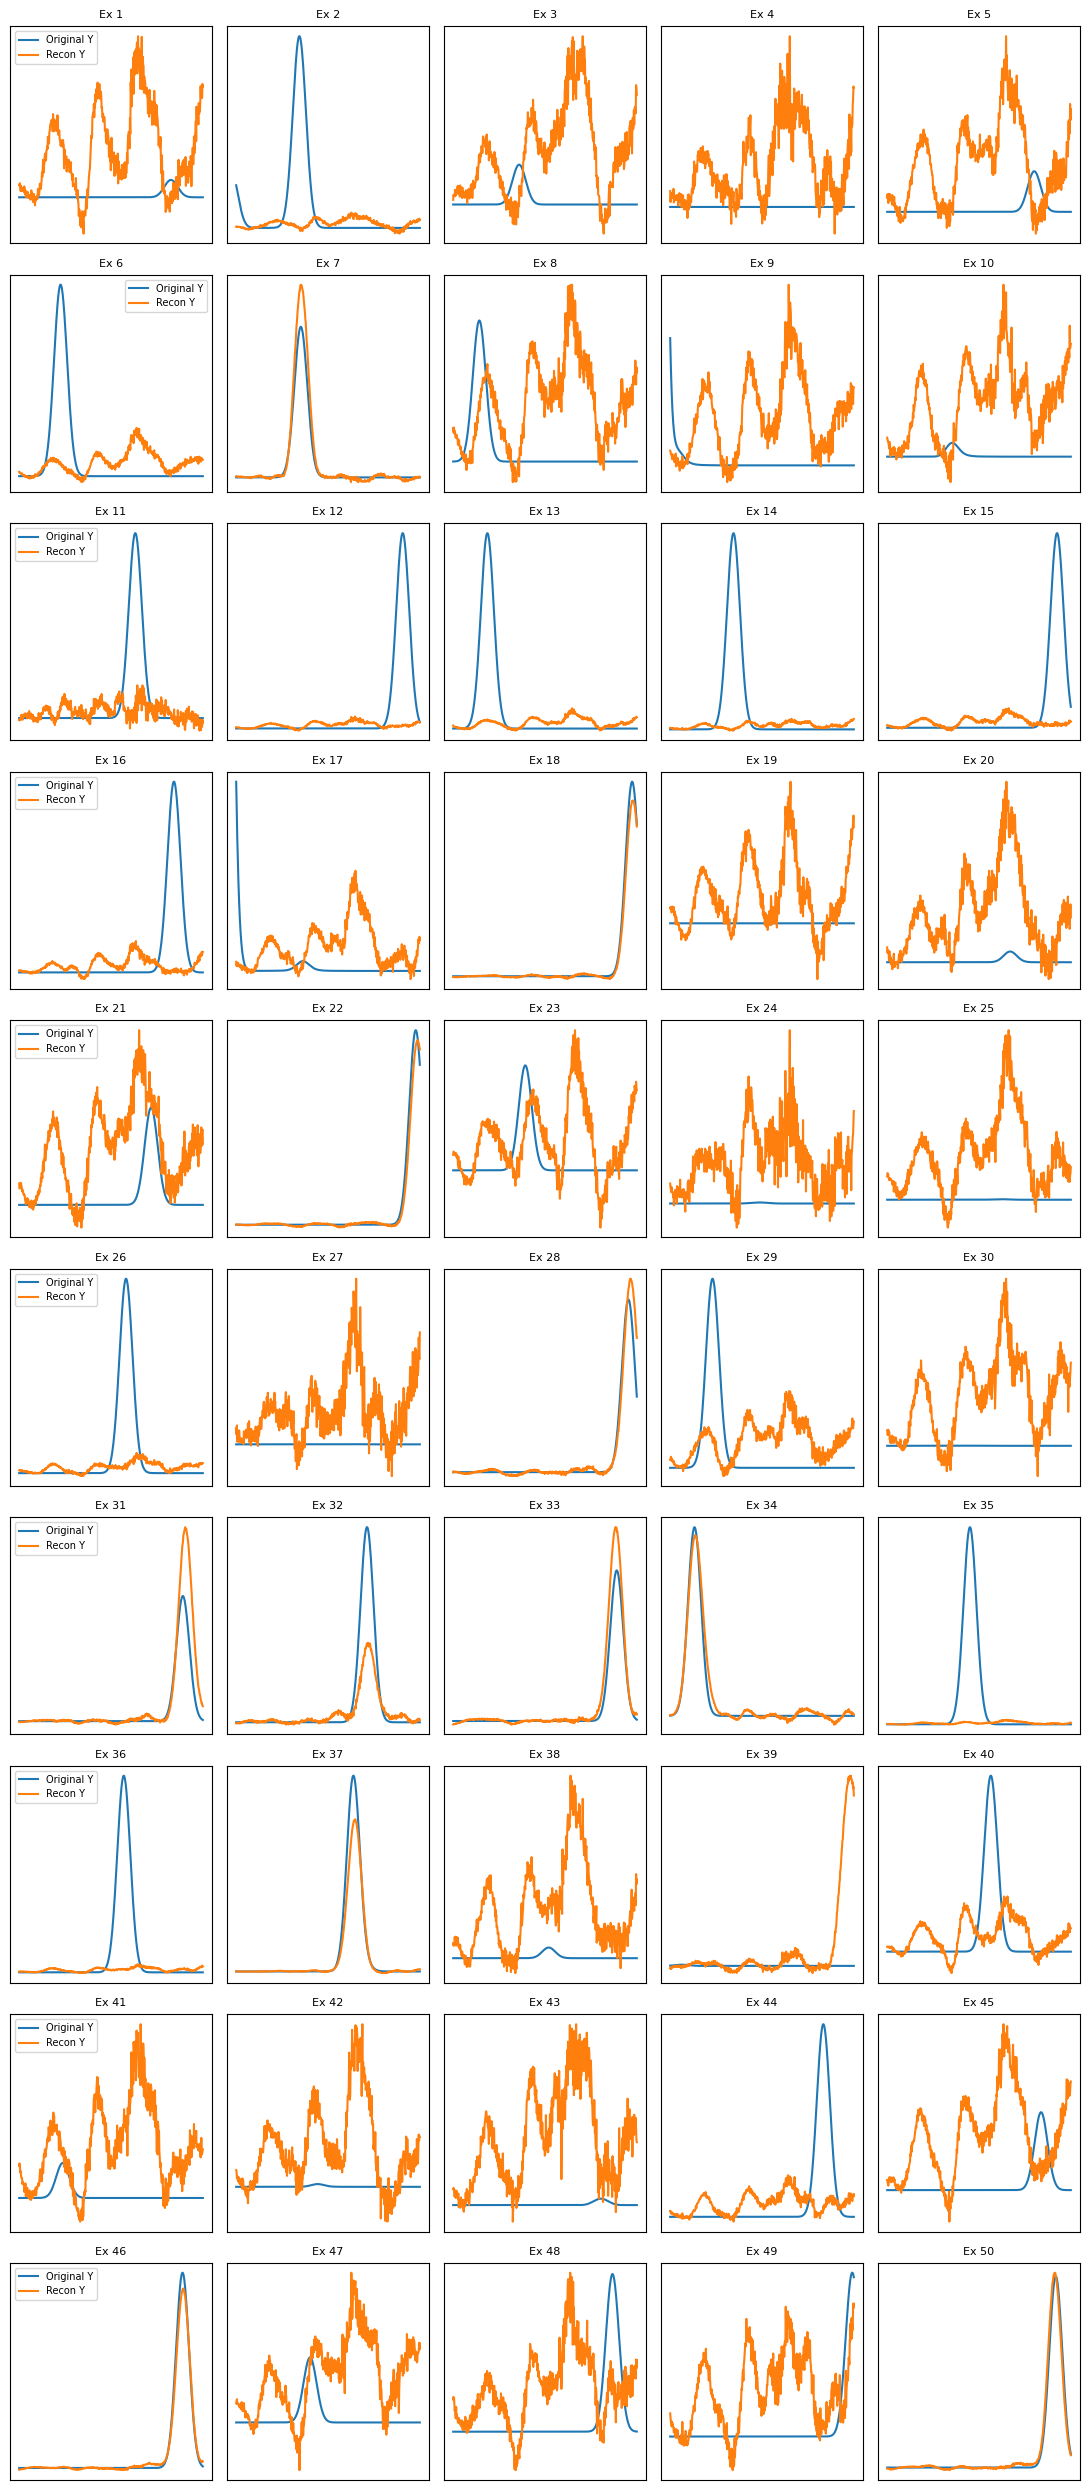

In [14]:
# Inverse de la standardisation
recon_x_orig = scaler_x.inverse_transform(recon_x)
recon_y_orig = scaler_y.inverse_transform(recon_y)

orig_x_orig = scaler_x.inverse_transform(orig_x)
orig_y_orig = scaler_y.inverse_transform(orig_y)

# ============================================================
# Affichage d'exemples (ici on affiche la première donnée du batch)
# ============================================================
index = 0

print("=== Données originales ===")
print("X:", orig_x_orig[index])
print("Y:", orig_y_orig[index])

print("\n=== Reconstruction ===")
print("X reconstruit:", recon_x_orig[index])
print("Y reconstruit:", recon_y_orig[index])

n_examples = 50
n_cols = 5
n_rows = n_examples // n_cols

plt.figure(figsize=(2.2*n_cols, 2.5*n_rows))
for i in range(n_examples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(orig_y_orig[i], label='Original Y')
    plt.plot(recon_y_orig[i], label='Recon Y')
    plt.title(f"Ex {i+1}", fontsize=8)
    plt.xticks([])
    plt.yticks([])
    if i % n_cols == 0:
        plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

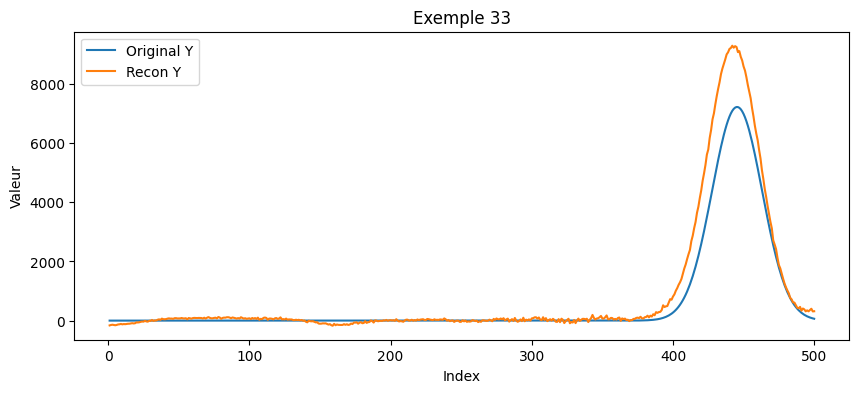

In [15]:

i = 32  # Choisis l'index de la courbe à afficher

x_axis = np.arange(1, 1 + len(orig_y_orig[i]))
plt.figure(figsize=(10, 4))
plt.plot(x_axis, orig_y_orig[i], label='Original Y')
plt.plot(x_axis, recon_y_orig[i], label='Recon Y')
plt.title(f"Exemple {i+1}", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.legend()
plt.show()